In [1]:
#IMPORTS 
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\DGaard\Desktop\Gits\MoleculeSim\ownSim")
#sys.path.append(r"C:\Users\EmilR\Documents\GitHub\MoleculeSim\ownSim")

#import forces as fc
import molecules as mc
import img3dto2d as i32
import util
#import random
#import copy
#from tqdm import tqdm

#mayavi imports:
from __future__ import absolute_import, division, print_function
from mayavi import mlab
import math

#video imports 
sys.path.append(r"C:\Users\DGaard\Desktop\Gits\MoleculeSim\videoStuff")
import video_format as vf
from skimage.transform import resize
from skimage.morphology import label

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [2]:
def old_load(name):
  with open(name, 'rb') as f:
    poss = np.load(f)
    radii = np.load(f)
  return poss, radii

In [3]:
# load radius and all molecule positions
filename = "simV3R_200_2000_ebb3d.npy"
filename_split = filename.split("_")
#points, radii= old_load(filename)
points, radii, acc = mc.load_molecule_steps(filename)

#sim values:
num_frames = int(filename_split[1]) #can be stored at eg. 100 steps pr frame (to save space)
num_molecules = len(points[0])
size_const = int(filename_split[2])

#image values
image_size = np.array([size_const,size_const])
sigma_scale = 3 #gauss values

frames = [0,len(points) - 1] #select frames to plot
print("frames:" , num_frames, "molecules: ",  num_molecules ," image size:", image_size)

frames: 200 molecules:  150  image size: [2000 2000]


In [4]:
plot = True
animate = True
video = True

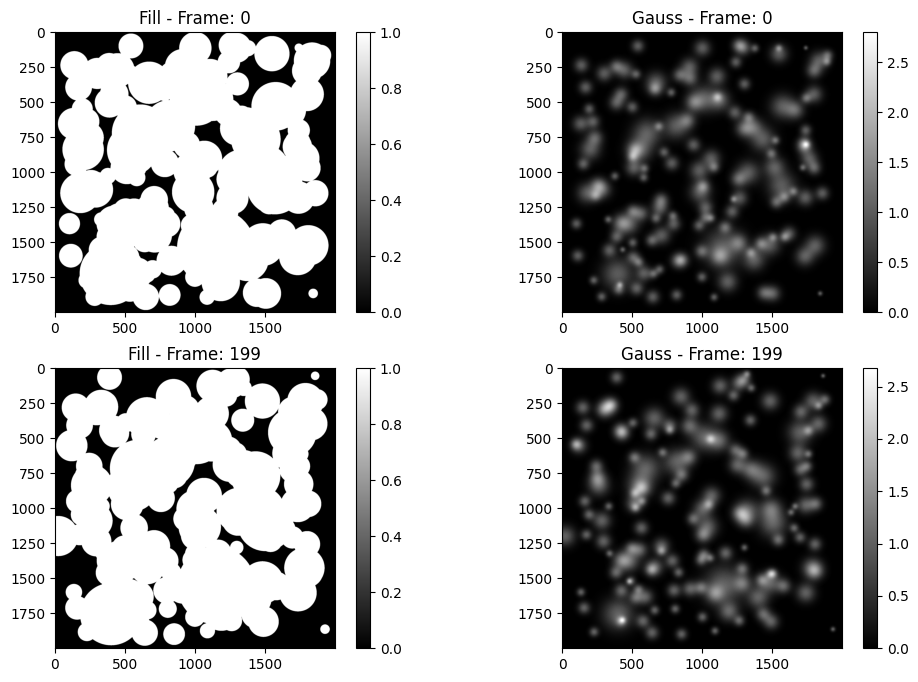

In [5]:
imgs_gauss = []
imgs_fill = []

if plot:
  #plot frames

  plt.figure(figsize=(12,4*len(frames)))
  for i,f in enumerate(frames):

    _p2dr = list(zip(np.array(points[f])[:,:2],radii))
    
    plt.subplot(len(frames),2,(i)*2+1)
    plt.title(f"Fill - Frame: {f}")
    _img_fill = i32.get_3d_to_2d_img(_p2dr,image_size)

    im_ratio = _img_fill.shape[0]/_img_fill.shape[1]
    plt.imshow(_img_fill,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    plt.subplot(len(frames),2,(i)*2+2)
    plt.title(f"Gauss - Frame: {f}")
    _img_gauss = i32.get_3d_to_2d_img_gauss(_p2dr,image_size,sigma_scale)
    plt.imshow(_img_gauss,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    imgs_fill.append(_img_fill)
    imgs_gauss.append(_img_gauss)

  plt.show()

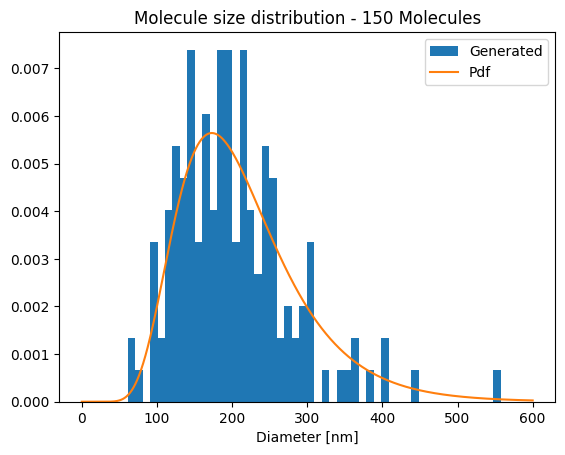

In [6]:
#radius distribution
x = np.linspace(0.1,600, 1000)
res = [util.pdf(i) for i in x]

plt.figure()
plt.hist(radii * 2,bins = 50, density = True,label="Generated")
plt.plot(x,res,label="Pdf")
plt.title(f"Molecule size distribution - {num_molecules} Molecules")
plt.legend()
plt.xlabel("Diameter [nm]")
plt.show()

In [7]:
#mayavi visualize

box_size = np.array([size_const,size_const,size_const]) #may need to set the z value to differently
#max_radius = max(radii)
#print(max_radius)
if animate:

	xs = np.array([inner_list[0] for sublist in points for inner_list in sublist]).reshape((num_frames,num_molecules))
	ys = np.array([inner_list[1] for sublist in points for inner_list in sublist]).reshape((num_frames,num_molecules))
	zs = np.array([inner_list[2] for sublist in points for inner_list in sublist]).reshape((num_frames,num_molecules))
	mlab.clf()
	#mlab.points3d(0,0,0)

	# plt = mlab.points3d([0], [0], [0], resolution = 100, scale_factor = 100*2)
	# plt = mlab.points3d([300], [0], [0], resolution = 100, scale_factor = 200*2)
	#plt = mlab.points3d(points[0][:, 0], points[0][:, 1], points[0][:, 2], resolution = 10, scale_factor = radius*2)
	plt2 = mlab.points3d(points[0][:, 0], points[0][:, 1], points[0][:, 2], radii*2, resolution = 10, scale_mode = "scalar", scale_factor = 1)
	mlab.axes(extent = [0,box_size[0],0,box_size[1],0,box_size[2]])#ranges = [-100,500,-200,200,-200,200]
	text_position = (0,0,0)
	text_actor = mlab.text3d(500,150, 510, "TESTING", scale = 40, color = (0,0,0))
	@mlab.animate(delay = 100, ui = True, support_movie = True) #delay = 100
	def anim():
		f = mlab.gcf()
		while True:
			#temp = "step: "
			for step in range(len(xs)):#num_steps
				x = xs[step]#points[step][:, 0]
				y = ys[step]#points[step][:, 1]
				z = zs[step]#points[step][:, 2]
				plt2.mlab_source.set(x=x, y=y, z=z)
				# for i in range(num_molecules):
  			# 		plt[i].mlab_source.set(x=x[i], y=y[i], z=z[i])
				text_actor.text = f"Frame: {step}"
				
				yield


	anim()
	mlab.show()

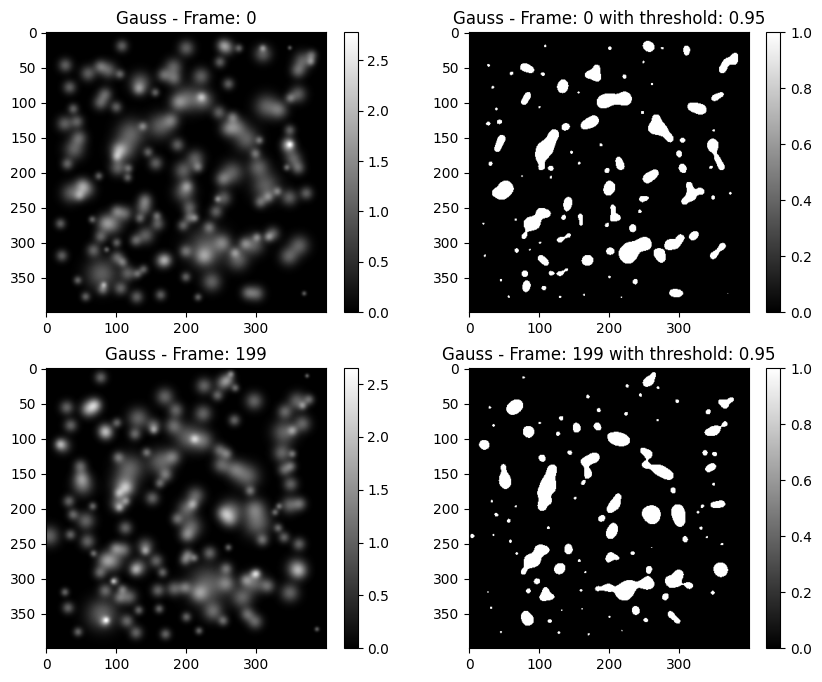

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]


In [8]:
#image stuff:

def process_our_image(img):
  #need to smooth?
  #remove boarder?

  return label(img)

L= 50

#apply threshold:
threshold = 0.95
wanted_img_size = np.array([400,400])
image_frames = [resize(i,wanted_img_size) for i in imgs_gauss]


th_imgs = []

plt.figure(figsize=(10,4*len(image_frames)))
for i,img in enumerate(image_frames):
  plt.subplot(len(imgs_gauss),2,(i)*2+1)
  plt.title(f"Gauss - Frame: {frames[i]}")
  plt.imshow(img,cmap="gray")

  im_ratio = img.shape[0]/img.shape[1]
  plt.colorbar(fraction=0.045 * im_ratio)

  plt.subplot(len(imgs_gauss),2,(i)*2+2)
  plt.title(f"Gauss - Frame: {frames[i]} with threshold: {threshold}")
  _img_gauss_th = np.where(img > threshold,1,0)
  plt.imshow(_img_gauss_th,cmap="gray")
  plt.colorbar(fraction=0.045 * im_ratio)

  th_imgs.append(_img_gauss_th)
plt.show()
#print(type(th_imgs[0][0,0]))

#apply connected components
cc_imgs = [process_our_image(i) for i in th_imgs]

print(np.unique(cc_imgs))


F_list, G_list = vf.analyse_video(cc_imgs,L=L)

In [9]:
#info from the video:
threshold2 = 0.3
smooth = 1
skip_size = 24
size = wanted_img_size[0]


frames_240= vf.process_video(vf.VIDEO_PATH,threshold=threshold2,smooth=smooth,skip_size=skip_size,size=size)
used_frame = frames_240[:2]

F_list2, G_list2 = vf.analyse_video(used_frame,L=L)

#frames_240= vf.process_video(vf.VIDEO_PATH,threshold=threshold,smooth=smooth,skip_size=skip_size,size=size)


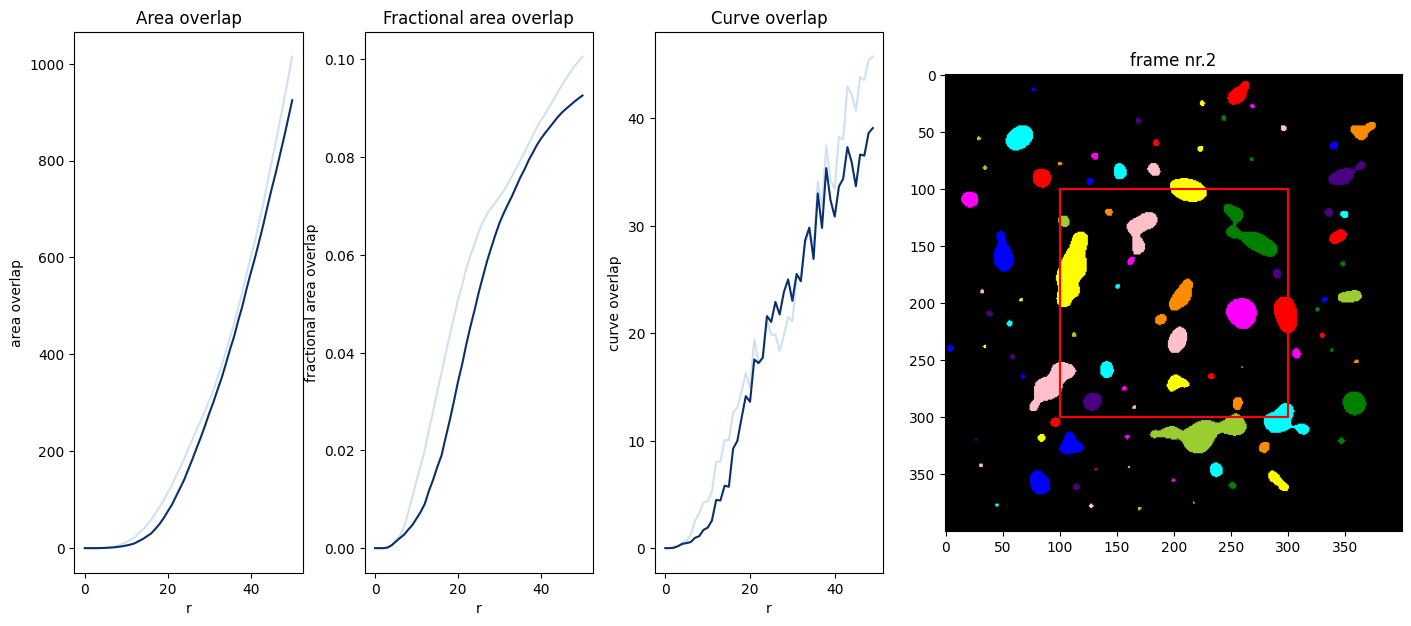

In [10]:
vf.visualize(cc_imgs,F_list,G_list, save=False)

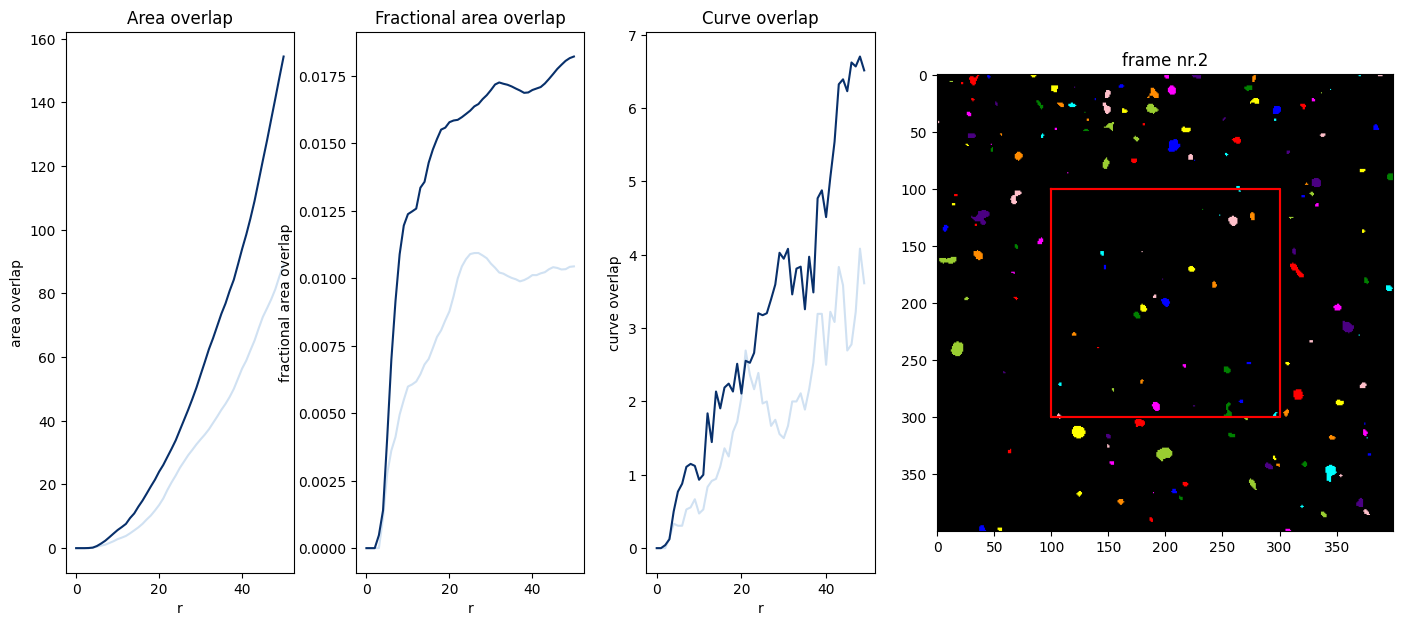

In [11]:
vf.visualize(used_frame,F_list2,G_list2)